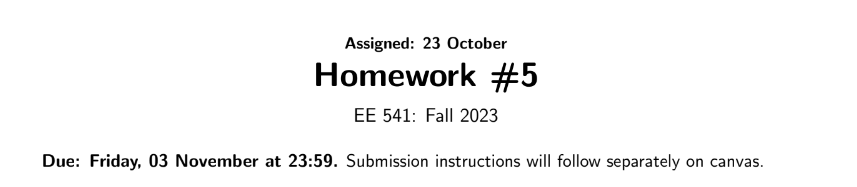

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
test_data_file = '/content/drive/MyDrive/EE 541/mnist_testdata (1).hdf5'
train_data_file = '/content/drive/MyDrive/EE 541/mnist_traindata (1).hdf5'

In [4]:
#Splitting to Train and Validation Data
with h5py.File(train_data_file, 'r+') as df:
  x_data = df['xdata'][:]
  y_data = df['ydata'][:]


X_train = x_data[:50000]
y_train = y_data[:50000]
X_val = x_data[:-50000]
y_val = y_data[:-50000]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((50000, 784), (50000, 10), (10000, 784), (10000, 10))

In [5]:
# Activations

class RelU():
  def __call__(self, x):
    return np.where(x >= 0, x, 0)

  def gradient(self, x):
    return np.where(x >= 0, 1, 0)

class TanH():
  def __call__(self, x):
    return 2 / (1 + np.exp(-2*x)) - 1

  def gradient(self, x):
    return 1 - np.power(self.__call__(x), 2)

class Softmax():
    def __call__(self, x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)

    def gradient(self, x):
        p = self.__call__(x)
        return p * (1 - p)

In [26]:
class MLPNetwork():
  def __init__(self, X, y ,X_val, y_val, epochs, learning_rate, neurons=128, batch_size=100, hidden_activation='RelU'):
    #data
    self.X = X
    self.y = y
    self.X_val = X_val
    self.y_val = y_val
    #HyperParameters
    self.neurons = neurons
    self.batch_size = batch_size
    self.epochs = epochs
    self.learning_rate = learning_rate
    #Activation function
    if hidden_activation == 'RelU':
      self.hidden_activation = RelU()
    else:
      self.hidden_activation = TanH()
    self.output_activation = Softmax()

    self.N = self.X.shape[0]
    #metrics
    self.train_loss = list()
    self.train_acc = list()
    self.val_loss = list()
    self.val_acc = list()
    self.metrics = [self.train_loss,self.train_acc,self.val_loss,self.val_acc]

  def cross_entropy(self, y, probabilities):
    # Clipping the values so that we avoid division by zero
    p = np.clip(probabilities, 1e-15, 1 - 1e-15)
    loss = - y * np.log(p) - (1 - y) * np.log(1 - p)
    return loss

  def gradient(self, y, probabilities):
    p = np.clip(probabilities, 1e-15, 1 - 1e-15)
    grad = - (y / p) + (1 - y) / (1 - p)
    return grad

  def accuracy(self, y, probabilities):
    y_true = np.argmax(y, axis=1)
    y_pred = np.argmax(probabilities, axis=1)
    acc = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return acc*100

  def initialize_weights(self, X, y):
    n_samples, n_features = X.shape
    _, n_outputs = y.shape
    # Hidden layer Weights
    limit   = 1 / math.sqrt(n_features)
    self.W  = np.random.uniform(-limit, limit, (n_features, self.neurons))
    self.w0 = np.zeros((1, self.neurons))
    # Output layer Weights
    limit   = 1 / math.sqrt(self.neurons)
    self.V  = np.random.uniform(-limit, limit, (self.neurons, n_outputs))
    self.v0 = np.zeros((1, n_outputs))

  def forward_pass(self, X):
    #-------- HIDDEN LAYER --------#
    hidden_input = X.dot(self.W) + self.w0
    hidden_output = self.hidden_activation(hidden_input)
    #------- OUTPUT LAYER ---------#
    output_input = hidden_output.dot(self.V) + self.v0
    y_pred = self.output_activation(output_input)
    return y_pred


  def fit(self, X, y):
    self.initialize_weights(self.X, self.y)

    for epoch in range(1, self.epochs+1):

      #Learning Rate Decay
      if epoch%20 == 0:
        self.learning_rate = self.learning_rate/2
        print(f"learning rate decayed: {self.learning_rate}")

      #divide to batches
      shuffle = np.random.permutation(self.N)
      X_batches = np.array_split(self.X[shuffle],self.N/self.batch_size)
      y_batches = np.array_split(self.y[shuffle],self.N/self.batch_size)

      for X_batch, y_batch in zip(X_batches,y_batches):
        train_acc = 0
        train_loss = 0

        # ---------------------------------- #
        #FORWARD PASS
        # ---------------------------------- #


        #-------- HIDDEN LAYER --------#
        hidden_input = X_batch.dot(self.W) + self.w0
        hidden_output = self.hidden_activation(hidden_input)
        #------- OUTPUT LAYER ---------#
        output_input = hidden_output.dot(self.V) + self.v0
        y_pred = self.output_activation(output_input)


        #Training Loss and Accuracy
        train_loss += self.cross_entropy(y_batch, y_pred)
        train_acc += self.accuracy(y_batch, y_pred)

        # ---------------------------------- #
        #BACK-PROPAGATION
        # ---------------------------------- #

        #Gradient WRT output layer
        grad_wrt_output = self.gradient(y_batch, y_pred) * self.output_activation.gradient(output_input)
        grad_v = hidden_output.T.dot(grad_wrt_output)
        grad_v0 = np.sum(grad_wrt_output, axis=0, keepdims=True)
        #Gradient WRT hidden layer
        grad_wrt_hidden = grad_wrt_output.dot(self.V.T) * self.hidden_activation.gradient(hidden_input)
        grad_w = X_batch.T.dot(grad_wrt_hidden)
        grad_w0 = np.sum(grad_wrt_hidden, axis=0, keepdims=True)

        #update weights
        self.V  -= self.learning_rate * grad_v
        self.v0 -= self.learning_rate * grad_v0
        self.W  -= self.learning_rate * grad_w
        self.w0 -= self.learning_rate * grad_w0



      #Training Loss and Accuracy
      train_loss = (np.sum(train_loss)/len(X_batches))
      self.train_loss.append(train_loss)
      train_acc = (train_acc/len(X_batches))
      self.train_acc.append(train_acc)

      #Validation Loss and Accuracy
      y_pred_val = self.forward_pass(self.X_val)
      val_loss = (self.cross_entropy(self.y_val, y_pred_val)).sum(axis=1).mean()
      #val_loss = (np.sum(val_loss)/len(X_batches))
      self.val_loss.append(val_loss)
      val_acc = self.accuracy(self.y_val, y_pred_val)
      self.val_acc.append(val_acc)

      print(f"Epoch: {epoch} Training loss: {train_loss}, Training Accuracy: {train_acc}%, Validation Loss: {self.val_loss[-1]}, Validation Accuracy: {val_acc}%")


  def plot_plots(self, name):
    epochs = list(range(1, len(self.train_acc) + 1))

    #breakpoints = [i%20 == 0 for i in epochs]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, self.train_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, self.val_acc, label='Validation Accuracy', marker='o')

    for epoch in [20, 40]:
        #if epoch == True:
        plt.axvline(x=epoch, color='red', linestyle='--', linewidth=0.8)

    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')
    plt.title(f'Learning Curves for {name}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

    ax1.plot(epochs, self.train_loss)
    ax1.set_title("Training Loss")
    ax1.set(xlabel='Epochs', ylabel='loss')

    ax2.plot(epochs, self.val_loss)
    ax2.set_title("Validation Loss")
    ax2.set(xlabel='Epochs', ylabel='Loss')

    # plt.figure(figsize=(10, 6))
    # plt.plot(epochs, self.train_loss, label='Training Loss', marker='*')
    # plt.plot(epochs, self.val_loss, label='Validation Loss', marker='*')
    # plt.xlabel('Epoch Number')
    # plt.ylabel('Loss')
    # plt.title(f'Learning Curves for {name}')
    # plt.legend()
    # plt.grid(True, linestyle='--', alpha=0.7)
    # plt.show()


Epoch: 1 Training loss: 1247.5550441137632, Training Accuracy: 0.19400000000000003%, Validation Loss: 63.11689057623176, Validation Accuracy: 8.63%
Epoch: 2 Training loss: 1246.1734770660184, Training Accuracy: 0.196%, Validation Loss: 63.11689057623176, Validation Accuracy: 8.63%
Epoch: 3 Training loss: 1248.9366111615082, Training Accuracy: 0.192%, Validation Loss: 63.11689057623176, Validation Accuracy: 8.63%
Epoch: 4 Training loss: 1243.410342970528, Training Accuracy: 0.2%, Validation Loss: 63.11689057623176, Validation Accuracy: 8.63%
Epoch: 5 Training loss: 1237.8840747795482, Training Accuracy: 0.20800000000000002%, Validation Loss: 63.11689057623176, Validation Accuracy: 8.63%
Epoch: 6 Training loss: 1250.3181782092533, Training Accuracy: 0.19%, Validation Loss: 63.11689057623176, Validation Accuracy: 8.63%
Epoch: 7 Training loss: 1271.041683925429, Training Accuracy: 0.16%, Validation Loss: 63.11689057623176, Validation Accuracy: 8.63%
Epoch: 8 Training loss: 1243.41034297052

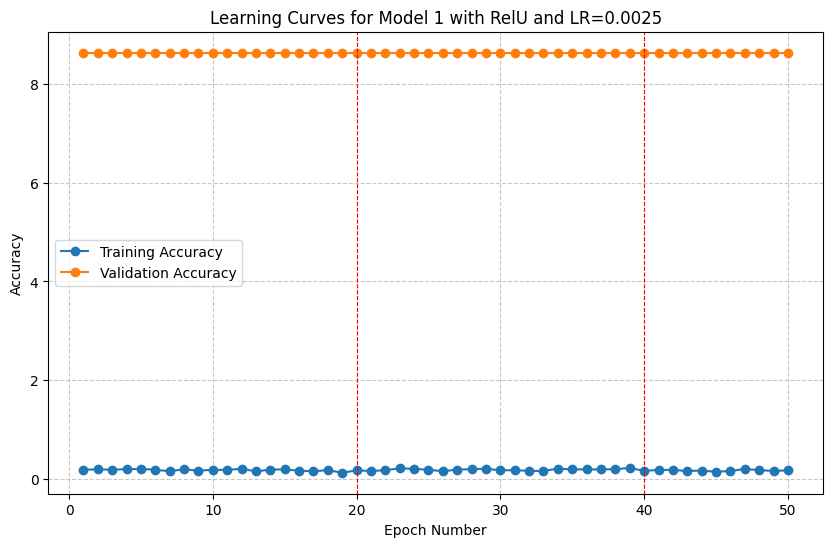

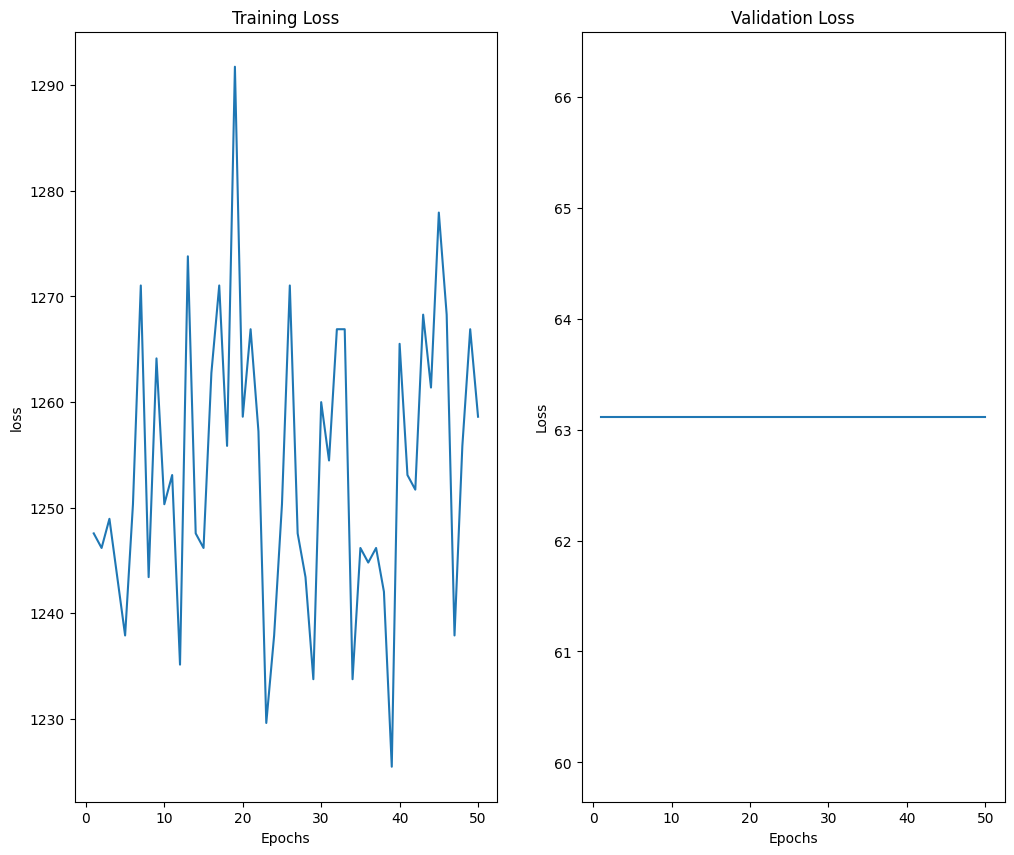

In [27]:
# MODEL 1 - RelU activation with learning rate = 0.01
model1 = MLPNetwork(X=X_train, y=y_train, X_val=X_val, y_val=y_val, epochs=50, learning_rate=0.01, neurons=128, batch_size=1000, hidden_activation='RelU')
model1.fit(X_train, y_train)
model1.plot_plots(f"Model 1 with RelU and LR={model1.learning_rate}")

Epoch: 1 Training loss: 13.333209484967288, Training Accuracy: 1.764%, Validation Loss: 0.6097718051324947, Validation Accuracy: 89.37%
Epoch: 2 Training loss: 8.294926378481058, Training Accuracy: 1.86%, Validation Loss: 0.41269799172613786, Validation Accuracy: 93.13%
Epoch: 3 Training loss: 6.5134860837053115, Training Accuracy: 1.886%, Validation Loss: 0.3366561846922627, Validation Accuracy: 94.28999999999999%
Epoch: 4 Training loss: 6.393467709439446, Training Accuracy: 1.902%, Validation Loss: 0.30275270805279303, Validation Accuracy: 94.93%
Epoch: 5 Training loss: 4.994938515841188, Training Accuracy: 1.908%, Validation Loss: 0.2444568942246934, Validation Accuracy: 95.87%
Epoch: 6 Training loss: 5.0366108090708055, Training Accuracy: 1.9140000000000001%, Validation Loss: 0.21850464557396426, Validation Accuracy: 96.38%
Epoch: 7 Training loss: 4.584482564667156, Training Accuracy: 1.91%, Validation Loss: 0.20421323964447133, Validation Accuracy: 96.7%
Epoch: 8 Training loss: 4.

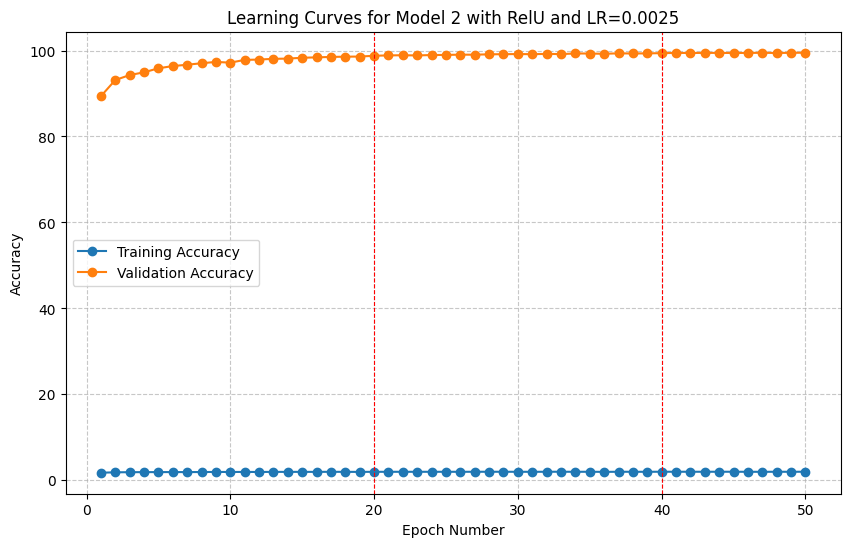

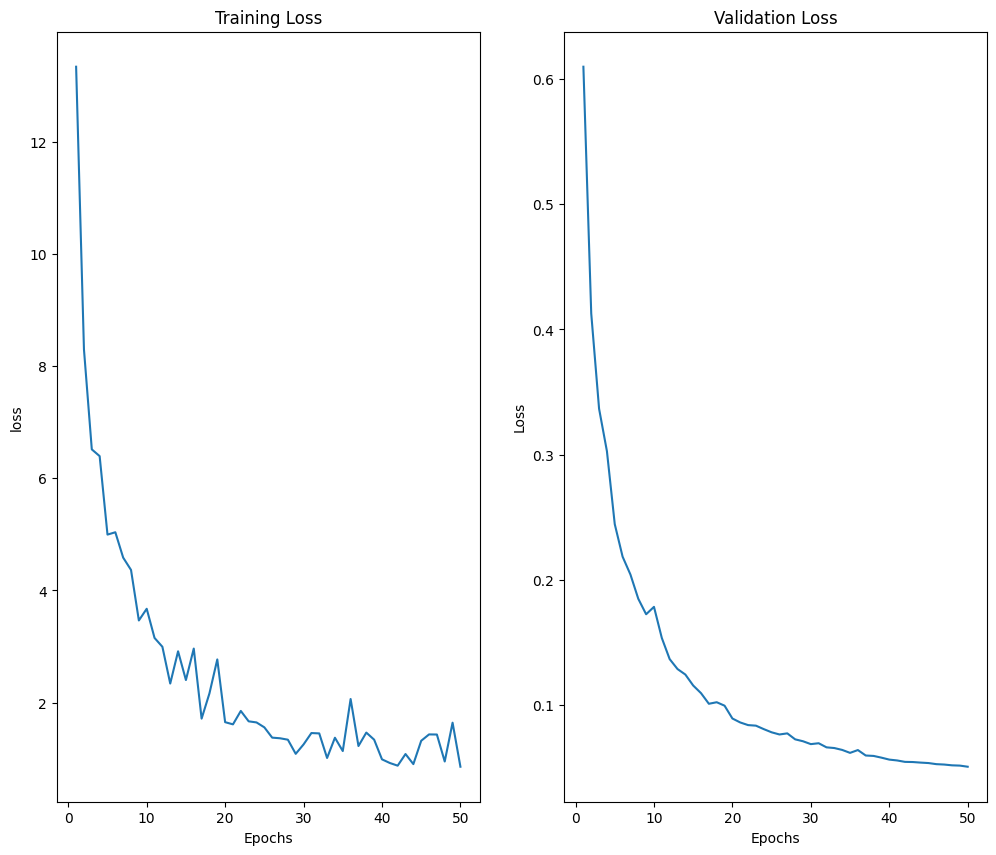

In [28]:
# MODEL 2 - RelU activation with learning rate = 0.001
model2 = MLPNetwork(X=X_train, y=y_train, X_val=X_val, y_val=y_val, epochs=50, neurons=128, learning_rate=0.001, batch_size=1000, hidden_activation='RelU')
model2.fit(X_train, y_train)
model2.plot_plots(f"Model 2 with RelU and LR={model1.learning_rate}")

Epoch: 1 Training loss: 34.720309530337346, Training Accuracy: 1.5759999999999998%, Validation Loss: 1.6577639493071714, Validation Accuracy: 81.87%
Epoch: 2 Training loss: 19.66514803888328, Training Accuracy: 1.7519999999999998%, Validation Loss: 0.9837306305859376, Validation Accuracy: 86.42999999999999%
Epoch: 3 Training loss: 15.206689984080624, Training Accuracy: 1.77%, Validation Loss: 0.7774098821378795, Validation Accuracy: 88.55%
Epoch: 4 Training loss: 15.075924198078177, Training Accuracy: 1.7519999999999998%, Validation Loss: 0.6796284412241899, Validation Accuracy: 89.42999999999999%
Epoch: 5 Training loss: 14.380499733466818, Training Accuracy: 1.744%, Validation Loss: 0.6232233724291196, Validation Accuracy: 90.01%
Epoch: 6 Training loss: 12.518167079131842, Training Accuracy: 1.7920000000000003%, Validation Loss: 0.5865967189696858, Validation Accuracy: 90.5%
Epoch: 7 Training loss: 13.085182429971441, Training Accuracy: 1.7719999999999998%, Validation Loss: 0.55836234

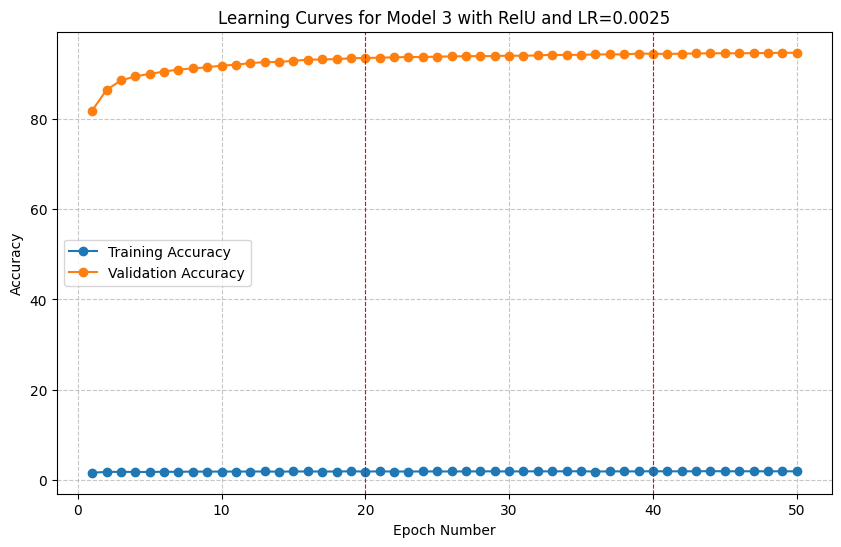

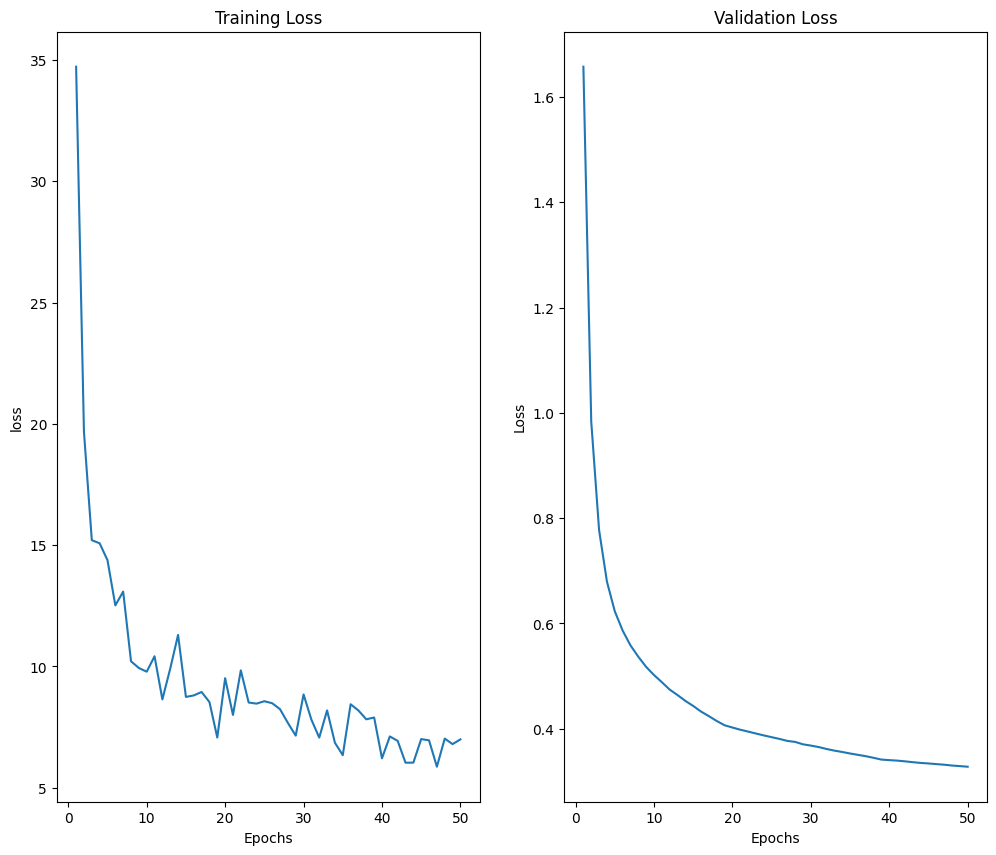

In [29]:
# MODEL 3 - RelU activation with learning rate = 0.0001
model3 = MLPNetwork(X=X_train, y=y_train, X_val=X_val, y_val=y_val, epochs=50, neurons=128, learning_rate=0.0001, batch_size=1000, hidden_activation='RelU')
model3.fit(X_train, y_train)
model3.plot_plots(f"Model 3 with RelU and LR={model1.learning_rate}")

<ipython-input-5-1f94141e01b5>:12: RuntimeWarning: overflow encountered in exp
  return 2 / (1 + np.exp(-2*x)) - 1


Epoch: 1 Training loss: 1262.7522816389585, Training Accuracy: 0.172%, Validation Loss: 62.30867385330093, Validation Accuracy: 9.8%
Epoch: 2 Training loss: 1235.120940684058, Training Accuracy: 0.212%, Validation Loss: 62.30867385330093, Validation Accuracy: 9.8%
Epoch: 3 Training loss: 1275.1863850686639, Training Accuracy: 0.154%, Validation Loss: 62.30867385330093, Validation Accuracy: 9.8%
Epoch: 4 Training loss: 1254.4628793524885, Training Accuracy: 0.184%, Validation Loss: 62.30867385330093, Validation Accuracy: 9.8%
Epoch: 5 Training loss: 1250.3181782092533, Training Accuracy: 0.19%, Validation Loss: 62.30867385330093, Validation Accuracy: 9.8%
Epoch: 6 Training loss: 1255.8444464002334, Training Accuracy: 0.182%, Validation Loss: 62.30867385330093, Validation Accuracy: 9.8%
Epoch: 7 Training loss: 1230.976239540823, Training Accuracy: 0.218%, Validation Loss: 62.30867385330093, Validation Accuracy: 9.8%
Epoch: 8 Training loss: 1266.8969827821936, Training Accuracy: 0.166%, V

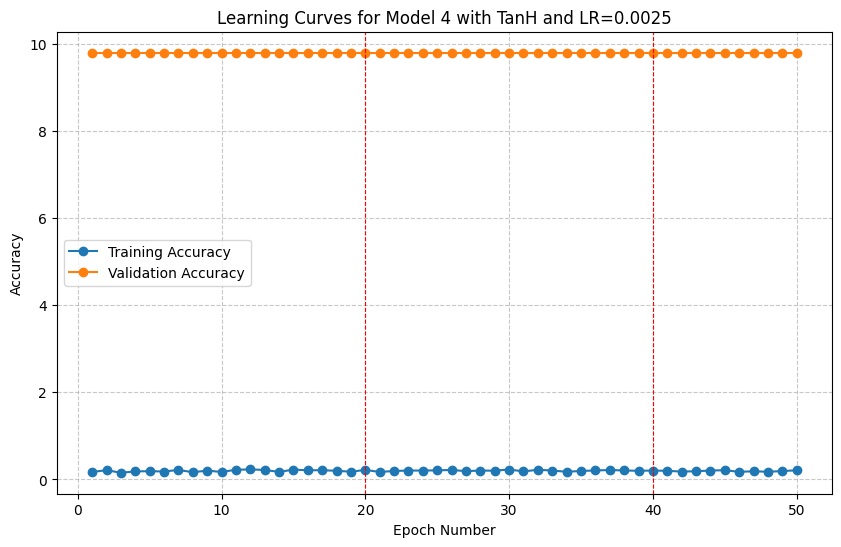

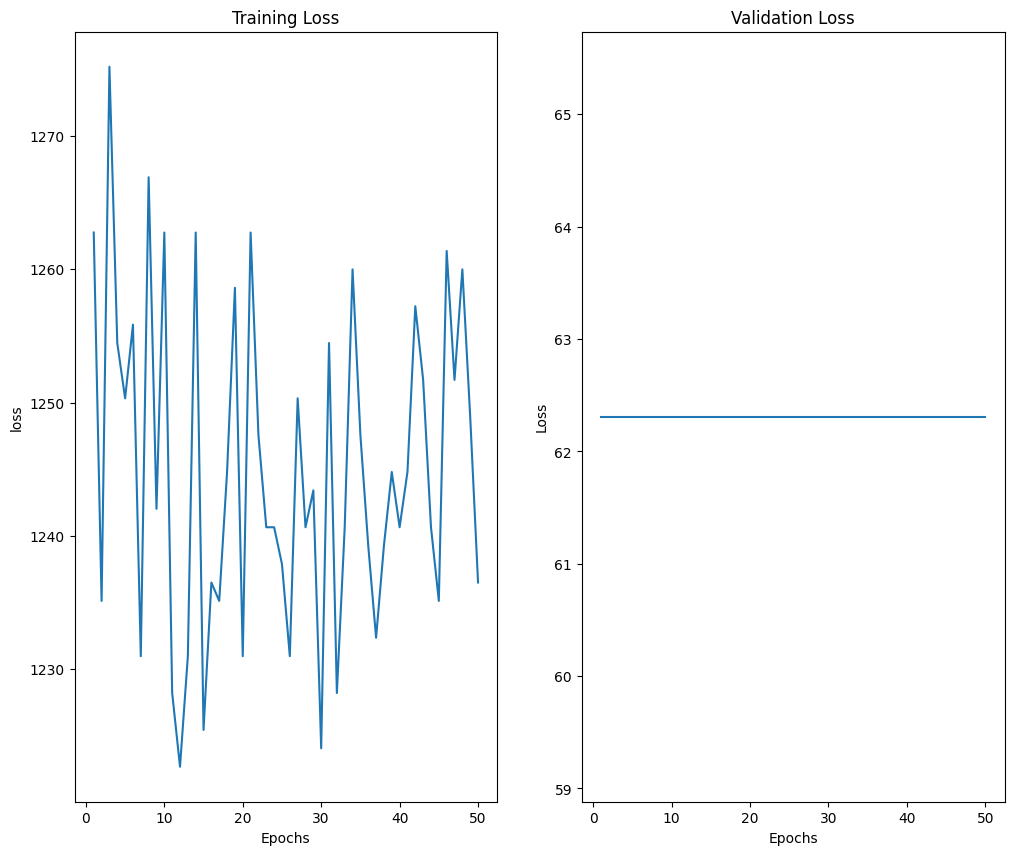

In [30]:
# MODEL 4 - TanH activation with learning rate = 0.01
model4 = MLPNetwork(X=X_train, y=y_train, X_val=X_val, y_val=y_val, epochs=50, neurons=128, learning_rate=0.01, batch_size=1000, hidden_activation='TanH')
model4.fit(X_train, y_train)
model4.plot_plots(f"Model 4 with TanH and LR={model1.learning_rate}")

Epoch: 1 Training loss: 13.539991355530866, Training Accuracy: 1.77%, Validation Loss: 0.5858716316318091, Validation Accuracy: 90.14%
Epoch: 2 Training loss: 10.272652981575007, Training Accuracy: 1.82%, Validation Loss: 0.4594708077281968, Validation Accuracy: 92.39%
Epoch: 3 Training loss: 8.271019308227674, Training Accuracy: 1.87%, Validation Loss: 0.3956135704635915, Validation Accuracy: 93.17%
Epoch: 4 Training loss: 8.521355654419981, Training Accuracy: 1.86%, Validation Loss: 0.3778757459716361, Validation Accuracy: 93.47%
Epoch: 5 Training loss: 5.630466282572926, Training Accuracy: 1.898%, Validation Loss: 0.313725571747661, Validation Accuracy: 94.78%
Epoch: 6 Training loss: 5.72482569031113, Training Accuracy: 1.908%, Validation Loss: 0.28117167661771403, Validation Accuracy: 95.35%
Epoch: 7 Training loss: 6.198262625538123, Training Accuracy: 1.892%, Validation Loss: 0.2568526516397647, Validation Accuracy: 95.78999999999999%
Epoch: 8 Training loss: 4.60058600740341, Trai

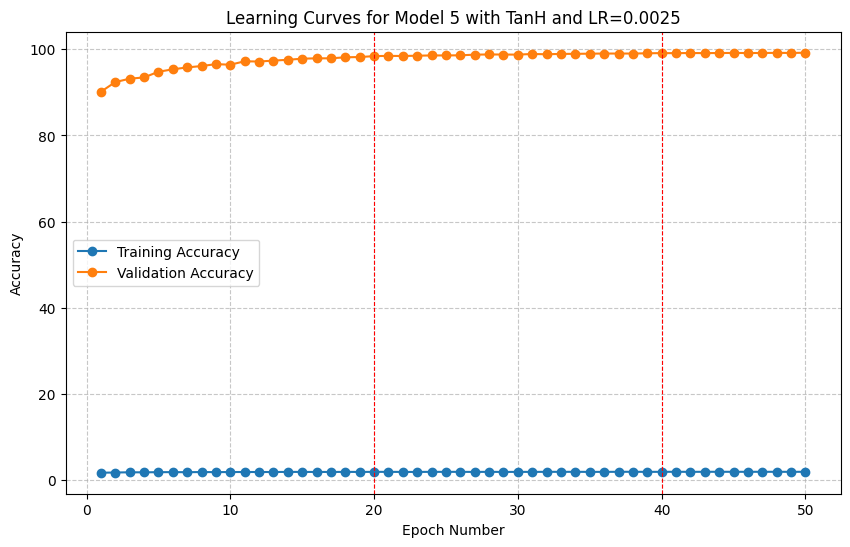

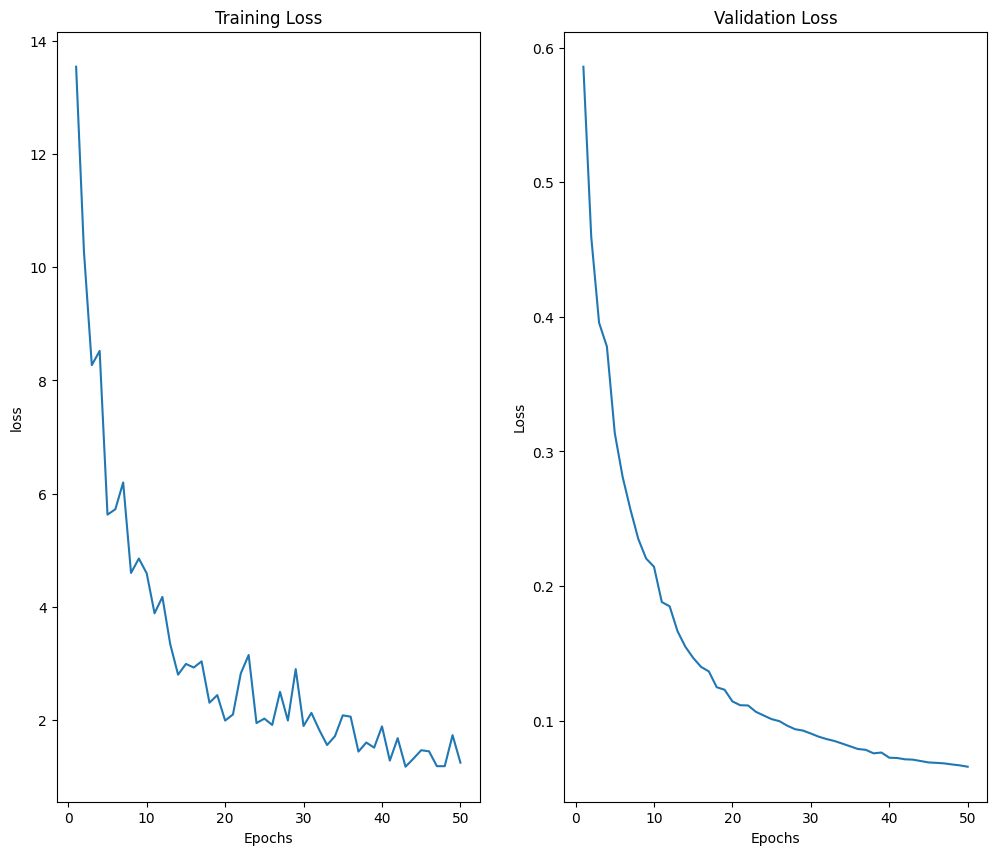

In [31]:
# MODEL 5 - TanH activation with learning rate = 0.001
model5 = MLPNetwork(X=X_train, y=y_train, X_val=X_val, y_val=y_val, epochs=50, neurons=128, learning_rate=0.001, batch_size=1000, hidden_activation='TanH')
model5.fit(X_train, y_train)
model5.plot_plots(f"Model 5 with TanH and LR={model1.learning_rate}")

Epoch: 1 Training loss: 31.462287919680776, Training Accuracy: 1.578%, Validation Loss: 1.4932791529540772, Validation Accuracy: 81.62%
Epoch: 2 Training loss: 20.754927236244285, Training Accuracy: 1.69%, Validation Loss: 0.9831682690198579, Validation Accuracy: 86.42%
Epoch: 3 Training loss: 17.115781037004602, Training Accuracy: 1.74%, Validation Loss: 0.7965975249251446, Validation Accuracy: 88.37%
Epoch: 4 Training loss: 14.961144840061086, Training Accuracy: 1.7519999999999998%, Validation Loss: 0.6998478226115701, Validation Accuracy: 89.24%
Epoch: 5 Training loss: 12.771215582491362, Training Accuracy: 1.794%, Validation Loss: 0.6427307406118637, Validation Accuracy: 89.83%
Epoch: 6 Training loss: 14.068926830147523, Training Accuracy: 1.776%, Validation Loss: 0.6040759113389329, Validation Accuracy: 90.25%
Epoch: 7 Training loss: 12.31943095472749, Training Accuracy: 1.8%, Validation Loss: 0.5752524164867152, Validation Accuracy: 90.69%
Epoch: 8 Training loss: 13.1084046257463

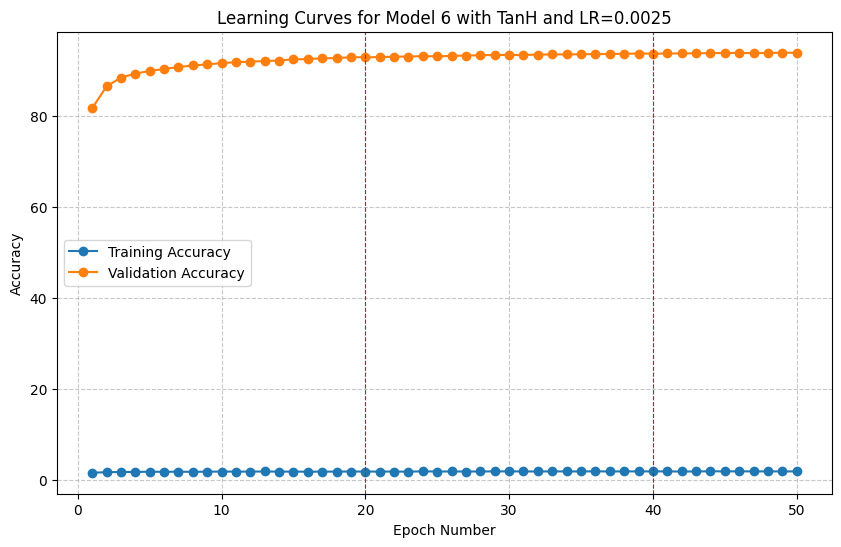

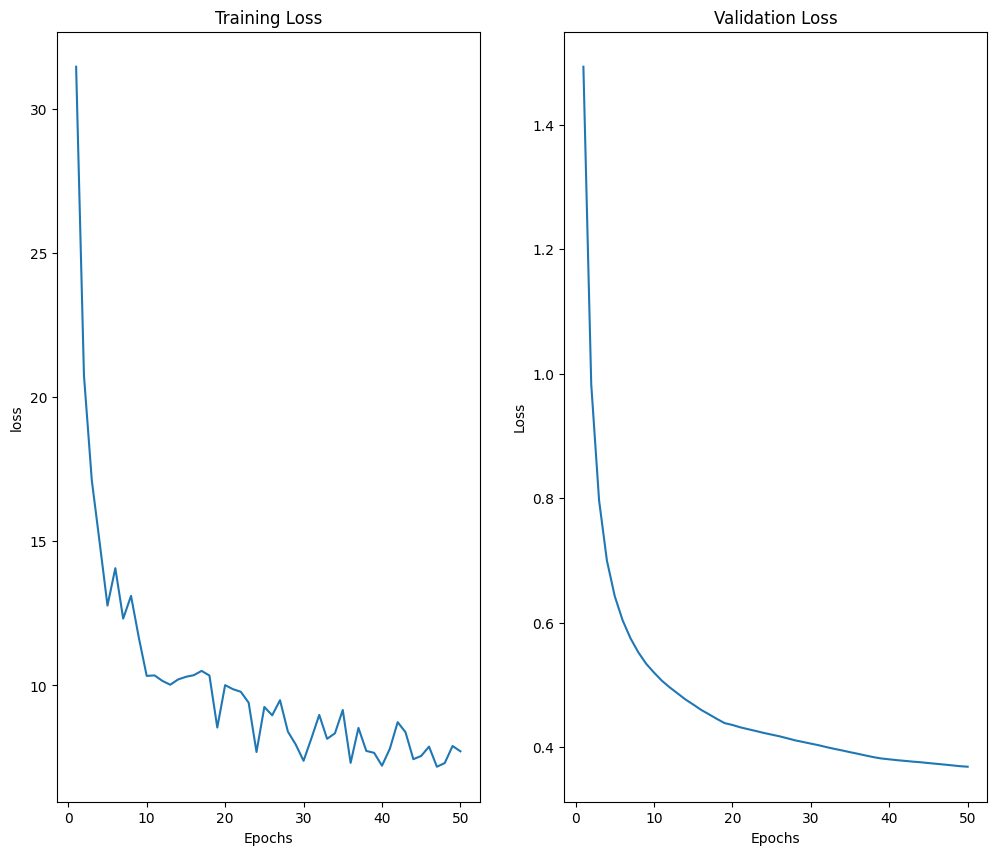

In [32]:
# MODEL 6 - TanH activation with learning rate = 0.001
model6 = MLPNetwork(X=X_train, y=y_train, X_val=X_val, y_val=y_val, epochs=50, neurons=128, learning_rate=0.0001, batch_size=1000, hidden_activation='TanH')
model6.fit(X_train, y_train)
model6.plot_plots(f"Model 6 with TanH and LR={model1.learning_rate}")

We have tried 6 Models with 3 different learning rates and 2 different activations and we come to a conclusion that MODEL 2 with **RelU Activation** and **learning_rate = 0.001** gives the best validation accuracy of **99.49%**

NOW we Test model 2 with our Test DATA

In [37]:
# TEST DATA
with h5py.File(test_data_file, 'r+') as df:
  x_test = df['xdata'][:]
  y_test = df['ydata'][:]

X_test = x_test[:10000]
Y_test = y_test[:10000]

X_test.shape, Y_test.shape

((10000, 784), (10000, 10))

In [41]:
# MODEL 2 - RelU activation with learning rate = 0.001

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------- #
predicted = model2.forward_pass(X_test)
test_loss = (model2.cross_entropy(Y_test, predicted)).sum(axis=1).mean()
test_accuracy = model2.accuracy(Y_test, predicted)

print(f'Test Loss: {test_loss} and Test Accuracy: {test_accuracy}')
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------- #


Test Loss: 0.1349948788043566 and Test Accuracy: 97.68


Hence We have Tested our second model and have got an **Accuracy of 97.68**